In [6]:
import os
import sys
import random
import warnings
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, UpSampling3D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv3D, Conv3DTranspose
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D
from keras.layers.pooling import MaxPooling3D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
path=os.path.join(BASE_DIR,"data")


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

def ShufflePic(image, mask):
    
    angle = [0,90,180,270]
    an=angle[random.randint(0,3)]
    choices=np.random.choice(a = 4, size = 3)
    blur= random.randint(1,7)
    #print(choices)
    img_result=np.zeros((image.shape[0], image.shape[1], image.shape[2], 3), dtype=np.uint8)
    msk_result = np.zeros((mask.shape[0], mask.shape[1], image.shape[2], 1), dtype=np.bool)


    for img, msk, count in zip(image, mask, range(len(image))):
        #normal image
        
        #noise images
        if choices[0]==0 or choices[1]==0 or choices[2]==0:
            img=noise_generator("s&p",img)
        
        
        #rotate images
        if choices[0]==5 or choices[1]==5 or choices[2]==5:
            h = img.shape[0]
            w = img.shape[1]
            
            center = (w / 2, h / 2)
            scale = 1.0
            M = cv2.getRotationMatrix2D(center, an, scale)
            img = cv2.warpAffine(img, M, (h, w))
            
            msk=msk.astype(np.uint8)
            msk = cv2.warpAffine(msk, M, (h, w))
            msk=np.expand_dims(msk, axis=-1)
        
        #blur images
        if choices[0]==5 or choices[1]==5 or choices[2]==5:
            try:
                img=cv2.blur(img,(blur, blur),0)
            except Exception as e:
                print(e)
                
#        cv2.imshow("result", img)
#        cv2.waitKey(0)
            #msk=cv2.GaussianBlur(msk,(1, 1),0)
        img_result[count]=img
        msk_result[count]=msk
        
    return img_result, msk_result

    

    
def noise_generator (noise_type,image):
    """
    Generate noise to a given Image based on required noise type
    
    Input parameters:
        image: ndarray (input image data. It will be converted to float)
        
        noise_type: string
            'gauss'        Gaussian-distrituion based noise
            'poission'     Poission-distribution based noise
            's&p'          Salt and Pepper noise, 0 or 1
            'speckle'      Multiplicative noise using out = image + n*image
                           where n is uniform noise with specified mean & variance
    """
    row,col,ch= image.shape
    if noise_type == "gauss":  
        print(noise_type)
        mean = 0.0
        var = 0.01
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == "s&p":
        #print(noise_type)
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        print(noise_type)
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type =="speckle":
        print(noise_type)
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image

def image_generator(image, mask, batch_size = 2):
    image_size=image.shape[2]
    depth=image.shape[1]
    projects=image.shape[0]
    while True:
            
          batch_paths = np.random.choice(a = projects, size = batch_size)
          # Select files (paths/indices) for the batch
          X_train = np.zeros((batch_size, depth, image_size, image_size, 3), dtype=np.uint8)
          Y_train = np.zeros((batch_size, depth, image_size, image_size, 1), dtype=np.bool)
          

          for i, count in zip(batch_paths, range(batch_size)):
            
              X_train[count], Y_train[count] = ShufflePic(image[i], mask[i])
          #print(X_train.shape)
          yield(X_train, Y_train)

X_train=np.load(os.path.join(path,"img32.npy"))
Y_train=np.load(os.path.join(path,"msk32.npy"))
print("X train:",X_train.shape,"\n")
print("Y train:",Y_train.shape,"\n")
IMG_CHANNELS = X_train.shape[4]
IMG_DEPTH=X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_HEIGHT = X_train.shape[3]


#image_generator(X_train,Y_train,  BATCH_SIZE)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

X train: (65, 32, 256, 256, 3) 

Y train: (65, 32, 256, 256, 1) 



In [26]:

def Unet(input_size = (IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input((input_size))
    s = Lambda(lambda x: x / 255) (inputs)


    c1 = Conv3D(16, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv3D(16, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c1)
    p1 = MaxPooling3D((2, 2, 2), padding='same', data_format='channels_last') (c1)

    c2 = Conv3D(32, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv3D(32, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c2)
    p2 = MaxPooling3D((2, 2, 2), padding='same', data_format='channels_last') (c2)

    c3 = Conv3D(64, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv3D(64, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c3)
    p3 = MaxPooling3D((2, 2, 2), padding='same', data_format='channels_last') (c3)

    c4 = Conv3D(128, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv3D(128, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2), padding='same', data_format='channels_last') (c4)

    c5 = Conv3D(256, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv3D(256, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c5)

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same', data_format='channels_last') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv3D(128, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv3D(64, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c7)
    #
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv3D(32, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same', data_format='channels_last') (c8)
    u9 = concatenate([u9, c1], axis=4)
    c9 = Conv3D(16, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv3D(16, (3, 3, 3), activation='elu', kernel_initializer='he_normal', padding='same', data_format='channels_last') (c9)

    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid') (c9)


    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer ="adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
    #model.summary()
    return model


In [27]:
BATCH_SIZE=4
model = Unet()
#model.summary()
model_checkpoint = ModelCheckpoint('model4.h5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(image_generator(X_train,Y_train,  BATCH_SIZE), validation_data=image_generator(X_train,Y_train,  2),validation_steps=2, steps_per_epoch=6, epochs=200, callbacks=[model_checkpoint])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 256, 256, 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 32, 256, 256, 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 32, 256, 256, 1312        lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 32, 256, 256, 0           conv3d_58[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:125: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:130: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


6/6 [==============================] - 22s 4s/step - loss: 0.2583 - acc: 0.9001 - val_loss: 0.0749 - val_acc: 0.9876

Epoch 00001: loss improved from inf to 0.25829, saving model to model4.h5
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 0.1535 - acc: 0.9682 - val_loss: 0.0478 - val_acc: 0.9938

Epoch 00002: loss improved from 0.25829 to 0.15345, saving model to model4.h5
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.1182 - acc: 0.9806 - val_loss: 0.1297 - val_acc: 0.9737

Epoch 00003: loss improved from 0.15345 to 0.11822, saving model to model4.h5
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 0.1073 - acc: 0.9794 - val_loss: 0.0703 - val_acc: 0.9866

Epoch 00004: loss improved from 0.11822 to 0.10731, saving model to model4.h5
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 0.1039 - acc: 0.9790 - val_loss: 0.0454 - val_acc: 0.9935

Epoch 00005: loss improved from 0.10731 to 0.10392, saving

In [28]:
#Prediction
new_model = load_model('model4.h5')

In [29]:
print(X_train[0].shape)
preds_train = new_model.predict(X_train[:2], verbose=1)
preds_train_t = (preds_train > 0.7).astype(np.uint8)

(32, 256, 256, 3)
2/2 [==============================] - 2s 772ms/step


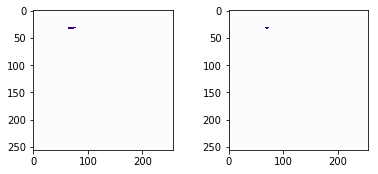

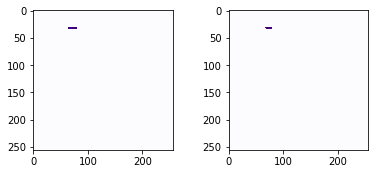

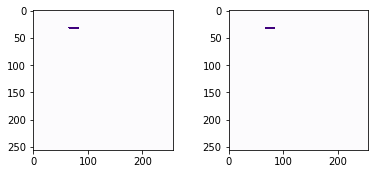

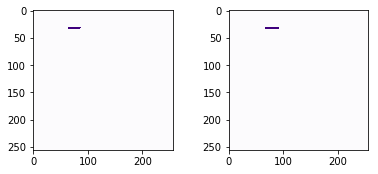

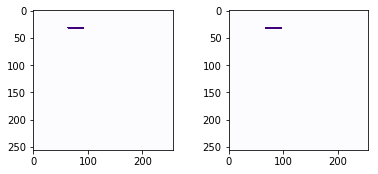

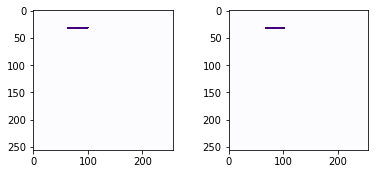

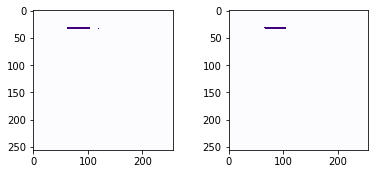

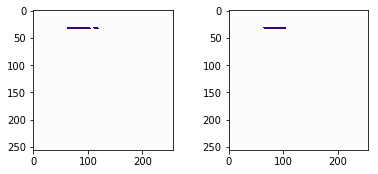

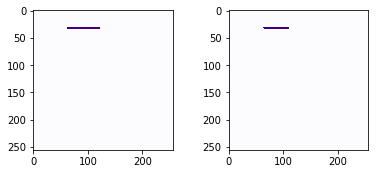

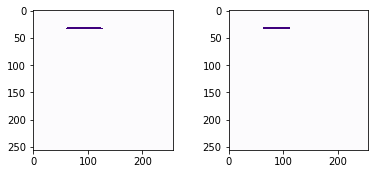

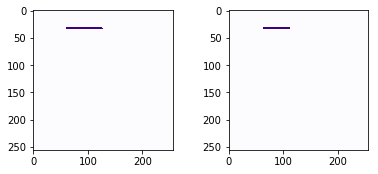

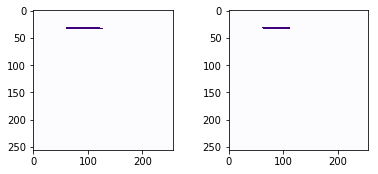

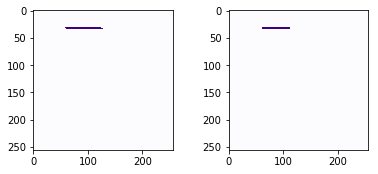

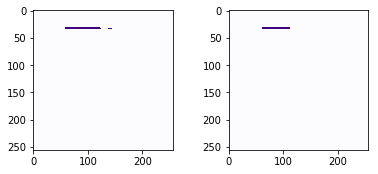

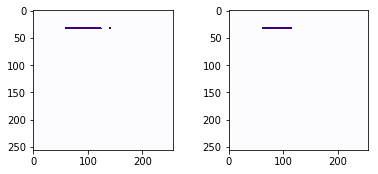

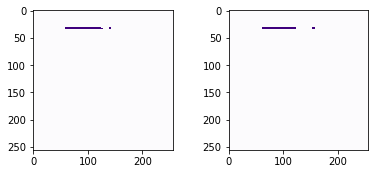

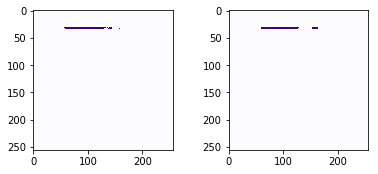

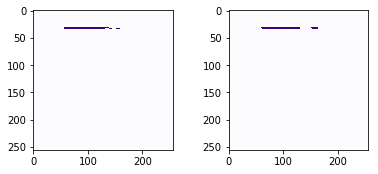

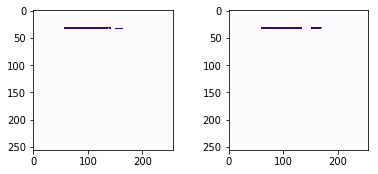

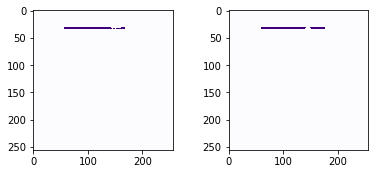

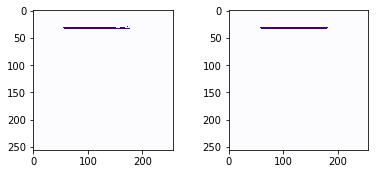

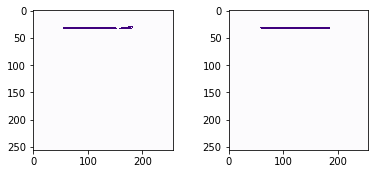

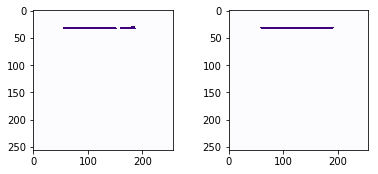

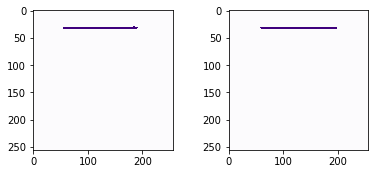

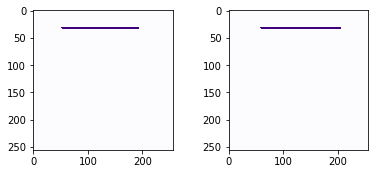

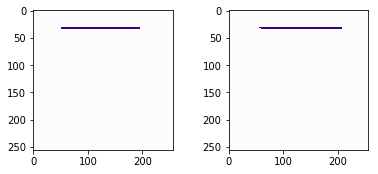

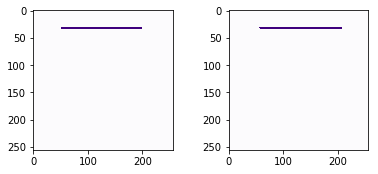

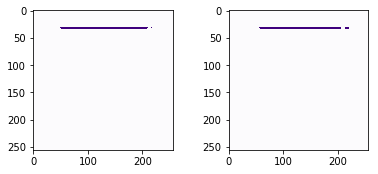

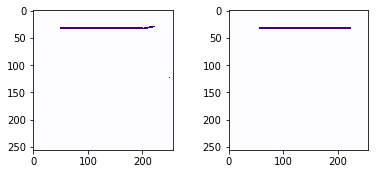

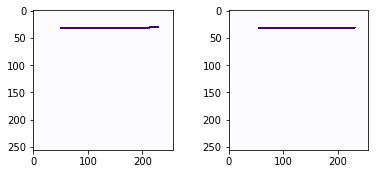

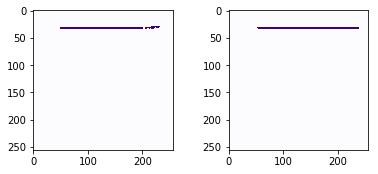

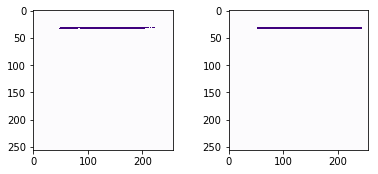

In [32]:
for i, count in zip(preds_train_t[0],range(len(preds_train_t[1]))):
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    #ax = fig.add_subplot(1, 2, 1)
    #ax.imshow(X_train[0][count])
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.reshape(i, (i.shape[1], i.shape[1])), cmap="Purples")

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(Y_train[0][count], (i.shape[1], i.shape[1])), cmap="Purples")

In [1]:
import sys
print(sys.version)

3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]


3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
['/home/jupyter/Unet3D/test/imgTest.npy']
5/5 [==============================] - 7s 1s/step


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


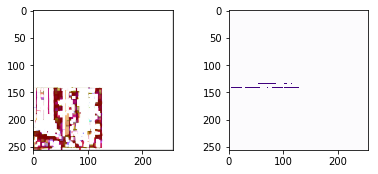

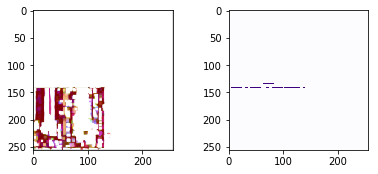

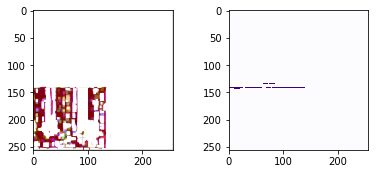

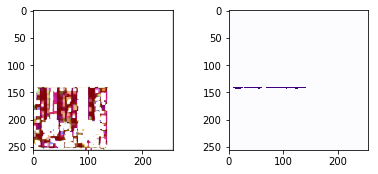

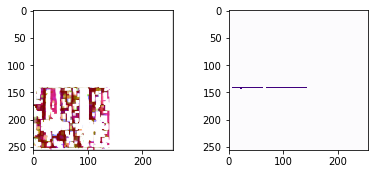

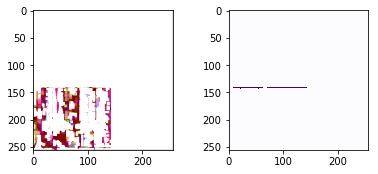

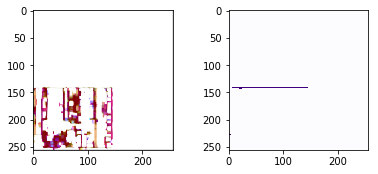

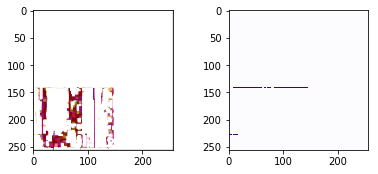

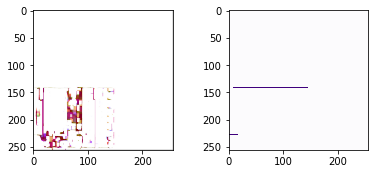

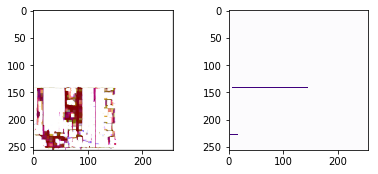

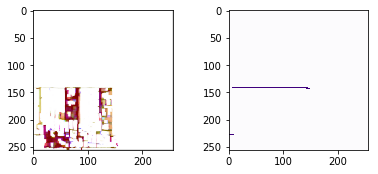

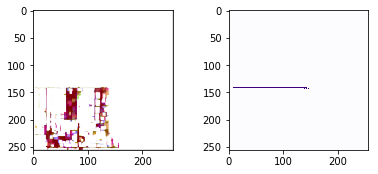

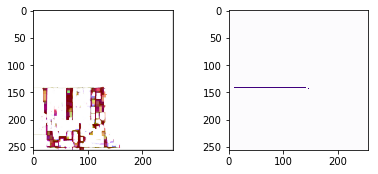

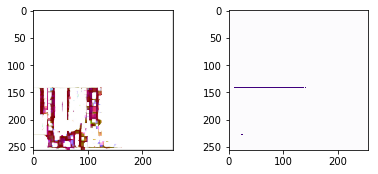

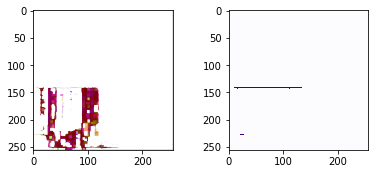

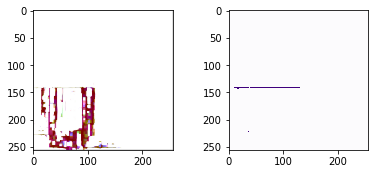

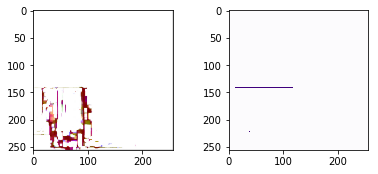

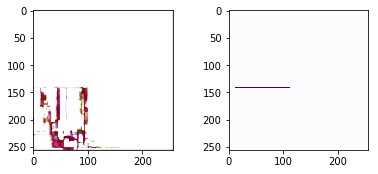

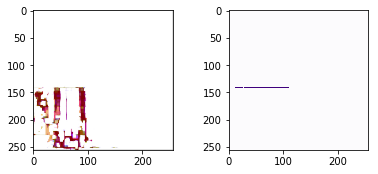

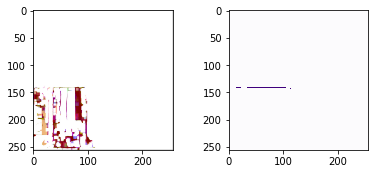

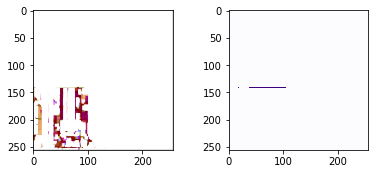

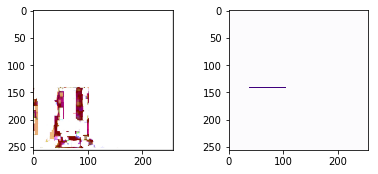

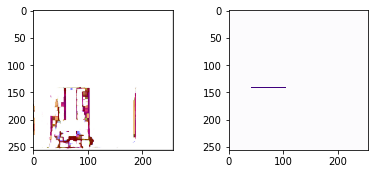

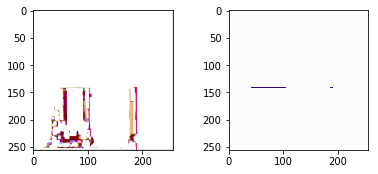

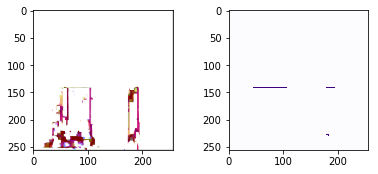

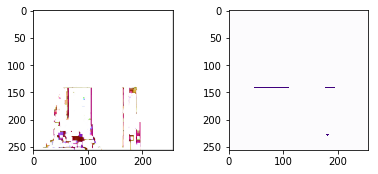

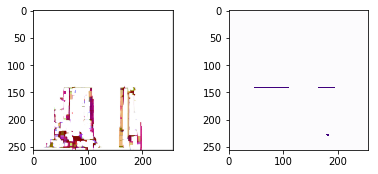

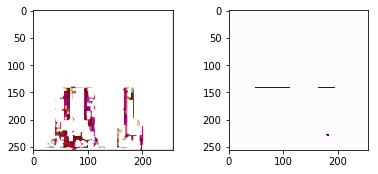

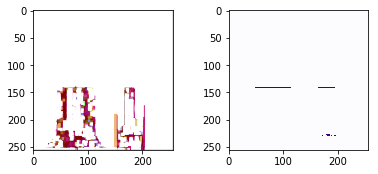

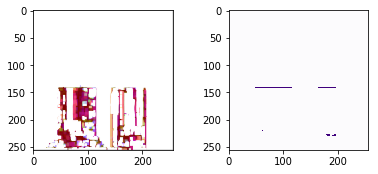

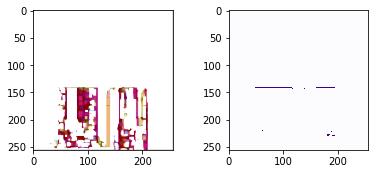

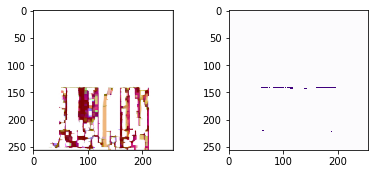

In [33]:
import sys
import glob
import os


print(sys.version)
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
path=os.path.join(BASE_DIR,"test")
file=glob.glob(os.path.join(path,"*.npy"))
file=[i for i in file if i.split("/")[-1] == "imgTest.npy"]
print(file)
#Prediction
new_model = load_model('model4.h5')
for f in file:
    X_train=np.load(f)
    
    preds_train = new_model.predict(X_train[:5], verbose=1)
    preds_train_t = (preds_train > 0.8).astype(np.uint8)
    


    for i, count in zip(preds_train_t[1],range(len(preds_train_t[1]))):
    
        
        
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(X_train[1][count], cmap="Purples")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(i, (i.shape[1], i.shape[1])), cmap="Purples")

    